In [114]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def plot_pdfs(data, mus, sigmas, labels, priors, y_train):
    ax = plt.axes(projection="3d")

    colors = [('b', 'viridis'), ('r', 'plasma')]

    fig2 = plt.figure()
    ax2 = fig2.gca()

    for cls in range(len(labels)):
        ax.scatter3D(data[y_train == cls][:, 0], data[y_train == cls][:, 1], np.ones(1) * -0.03, c=colors[cls][0])
        mu = np.asarray(mus[cls]).flatten()
        x = np.linspace(mu[0] - 3 * sigmas[cls][0, 0], mu[0] + 3 * sigmas[cls][0, 0], 40).flatten()
        y = np.linspace(mu[1] - 3 * sigmas[cls][1, 1], mu[1] + 3 * sigmas[cls][1, 1], 40).flatten()

        X, Y = np.meshgrid(x, y)
        pos = np.empty(X.shape + (2,))
        pos[:, :, 0] = X
        pos[:, :, 1] = Y
        print(pos.shape)
        rv = multivariate_normal([mu[0], mu[1]], sigmas[cls])
        Z = rv.pdf(pos)
        ax.plot_surface(X, Y, Z, cmap=colors[cls][1], linewidth=0.2, alpha=0.9, shade=True)

        ax2.contour(X, Y, Z, cmap='coolwarm')
    x = np.linspace(np.min(data[:, 0]), np.max(data[:, 0]), 40).flatten().T
    y = np.linspace(np.min(data[:, 1]), np.max(data[:, 1]), 40).flatten().T
    b0 = 0.5 * mus[0].T.dot(np.linalg.pinv(sigmas[0])).dot(mus[0])
    b1 = -0.5 * mus[1].T.dot(np.linalg.pinv(sigmas[1])).dot(mus[1])
    b = b0 + b1 + np.log(priors[0]/priors[1])
    a = np.linalg.pinv(sigmas[0]).dot(mus[1] - mus[0])
    x1 = -(b + a[0]*x) / a[1]
    ax2.plot(x, x1)

def plot_dec_boundary(train_data, test_x, prediction, test_y, mus, sigmas, priors, title):
    missed_0 = np.take(test_x, np.setdiff1d(np.where(prediction == 0), np.where(test_y == 0)), axis=0)
    missed_1 = np.take(test_x, np.setdiff1d(np.where(prediction == 1), np.where(test_y == 1)), axis=0)
    cl0 = np.delete(test_x, np.where(prediction != 0), axis=0)
    cl1 = np.delete(test_x, np.where(prediction != 1), axis=0)
    plt.plot(cl0[:, 0], cl0[:, 1], '.c')
    plt.plot(missed_0[:, 0], missed_0[:, 1], '.r')
    plt.plot(cl1[:, 0], cl1[:, 1], '.y')
    plt.plot(missed_1[:, 0], missed_1[:, 1], '.k')
    x = np.linspace(np.min(train_data[:, 0]), np.max(train_data[:, 0]), 40).flatten().T
    y = np.linspace(np.min(train_data[:, 1]), np.max(train_data[:, 1]), 40).flatten().T
    b0 = 0.5 * mus[0].T.dot(np.linalg.pinv(sigmas[0])).dot(mus[0])
    b1 = -0.5 * mus[1].T.dot(np.linalg.pinv(sigmas[1])).dot(mus[1])
    b = b0 + b1 + np.log(priors[0]/priors[1])
    a = np.linalg.pinv(sigmas[0]).dot(mus[1] - mus[0])
    x1 = -(b + a[0]*x) / a[1]
    plt.plot(x, x1)
    plt.title(title)
    plt.show()
    return




Train Accuracy :  0.98875


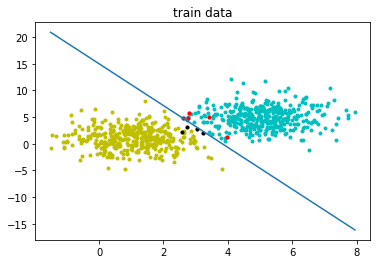

(40, 40, 2)
(40, 40, 2)


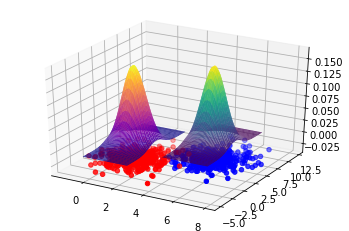

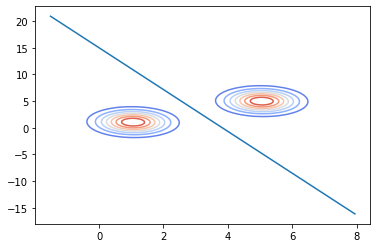

In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
def load_data(path):
  data = pd.read_csv(path,names=['x1', 'x2', 'y'])
  X = data.iloc[:, 0 : data.shape[1] - 1]
  y = data.iloc[:, data.shape[1] - 1]
  return X, y

def raw_data(path):
  data = pd.read_csv(path,names=['x1', 'x2', 'y'])
  return data

def fit(X_train, y_train, classes, priors, means):
  x, y = X_train.values, y_train.values
  for i, label in enumerate(classes):
    priors[i] = y[y == label].size / y.size
    means[i] = np.mean(x[y == label], axis=0)
  covariance_matrix = covariance(x, y, classes, means)
  return means, priors, covariance_matrix

def covariance(x, y, classes, means):
  covs = [0 for i in range(len(classes))]
  cov = np.zeros(shape=(x.shape[1], x.shape[1]))
  for i, label in enumerate(classes):
    members = x[y == label]
    x_mu = members - means[i]
    cov += (x_mu).T.dot(x_mu)
    cov /= x.shape[0] #delete if single
    covs[i] = cov # cov /= X.shape[0] out of loop if single
  return covs # return cov if single

def probability(x, mean, prior, covariance_matrix):
  xm = x - mean
  xm_covariance = (xm.dot(np.linalg.pinv(covariance_matrix))) * xm
  xm_covariance_sum = xm_covariance.sum(axis=1)
  return -0.5 * xm_covariance_sum + np.log(prior)

def predict(X_train, classes, means, priors, covariance_matrix):
  x = X_train.values
  probabilities = np.zeros((x.shape[0], priors.size))
  for i,_ in enumerate(classes):
    probabilities[:, i] = probability(
        x, means[i]
        , priors[i]
        , covariance_matrix[i]) # covariance_matrix -> if single
  return np.argmax(probabilities, axis=1)

def predict_proba(x):
  probabilities = np.zeros((x.shape[0], priors.size))
  for i,_ in enumerate(classes):
    probabilities[:, i] = probability(
        x, means[i]
        , priors[i]
        , covariance_matrix)
  return probabilities

X_train, y_train = load_data('/content/BC-Train1.csv')
classes = np.unique(y_train)
classes.sort()
means = np.zeros((classes.size, X_train.shape[1]))
priors = np.zeros(classes.size)
means, priors, covariance_matrix = fit(X_train, y_train, classes, priors, means)
predicted_ys = predict(X_train, classes, means, priors, covariance_matrix)

from sklearn.metrics import accuracy_score
print("Train Accuracy : ", accuracy_score(y_train, predicted_ys))

# Plots
plot_dec_boundary(X_train.values, X_train.values, predicted_ys, y_train.values, means, covariance_matrix,priors, "train data")
plot_pdfs(X_train.values, means, covariance_matrix, classes, priors, y_train.values)
plt.show()

Test Accuracy :  1.0


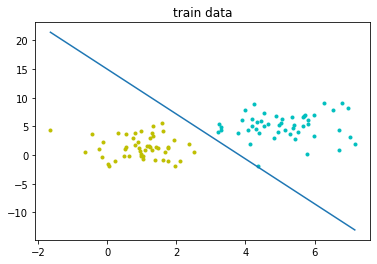

(40, 40, 2)
(40, 40, 2)


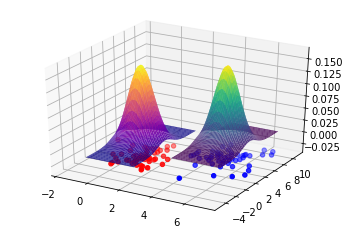

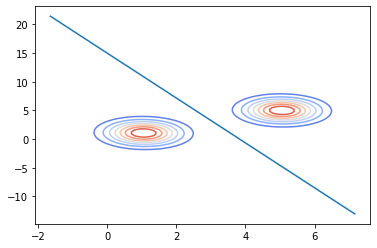

In [127]:
# report train and test accuracy for both datasets

X_test, y_test = load_data('/content/BC-Test1.csv')
predicted_ys = predict(X_test, classes, means, priors, covariance_matrix)
print("Test Accuracy : ", accuracy_score(y_test, predicted_ys))
plot_dec_boundary(X_test.values, X_test.values, predicted_ys, y_test.values, means, covariance_matrix,priors, "train data")
plot_pdfs(X_test.values, means, covariance_matrix, classes, priors, y_test.values)
plt.show()

Train Accuracy :  0.99125


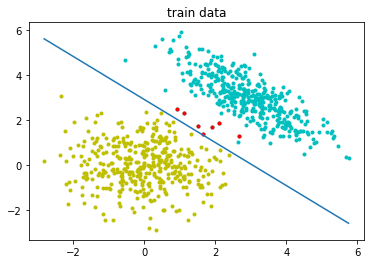

(40, 40, 2)
(40, 40, 2)


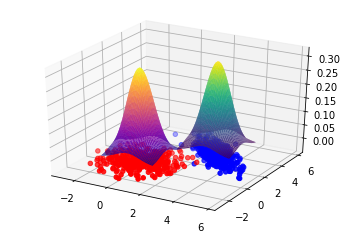

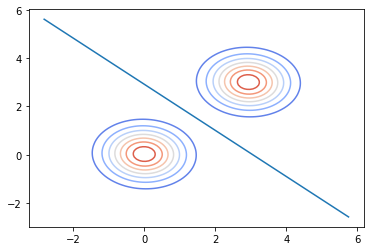

In [128]:
X_train1, y_train1 = load_data('/content/BC-Train2.csv')
classes = np.unique(y_train1)
classes.sort()
means = np.zeros((classes.size, X_train1.shape[1]))
priors = np.zeros(classes.size)
means, priors, covariance_matrix = fit(X_train1, y_train1, classes, priors, means)
predicted_ys1 = predict(X_train1, classes, means, priors, covariance_matrix)

# report train and test accuracy for both datasets
from sklearn.metrics import accuracy_score
print("Train Accuracy : ", accuracy_score(y_train1, predicted_ys1))

plot_dec_boundary(X_train1.values, X_train1.values, predicted_ys1, y_train1.values, means, covariance_matrix, priors, "train data")
plot_pdfs(X_train1.values, means, covariance_matrix, classes, priors, y_train1.values)
plt.show()



Test Accuracy :  1.0


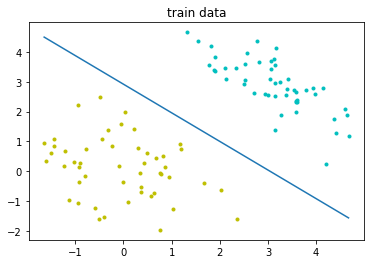

(40, 40, 2)
(40, 40, 2)


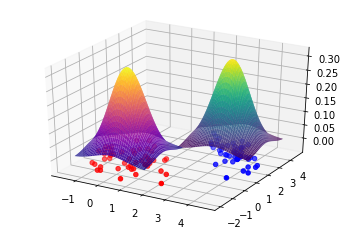

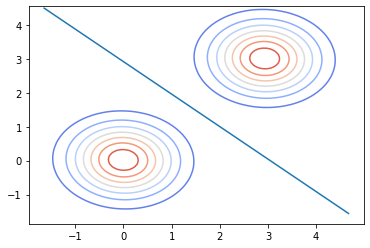

In [129]:
X_test1, y_test1 = load_data('/content/BC-Test2.csv')
predicted_ys1 = predict(X_test1, classes, means, priors, covariance_matrix)
print("Test Accuracy : ", accuracy_score(y_test1, predicted_ys1))

plot_dec_boundary(X_test1.values, X_test1.values, predicted_ys1, y_test1.values, means, covariance_matrix, priors, "train data")
plot_pdfs(X_test1.values, means, covariance_matrix, classes, priors, y_test1.values)
plt.show()

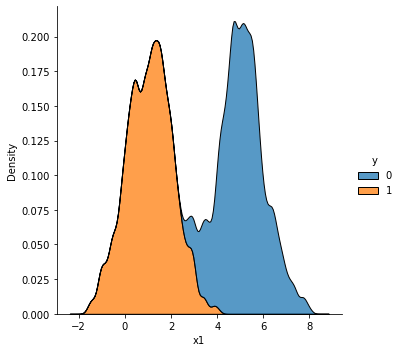

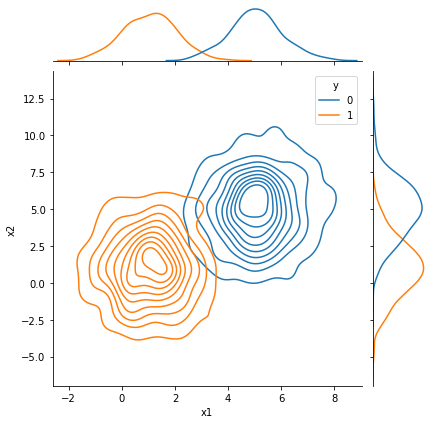

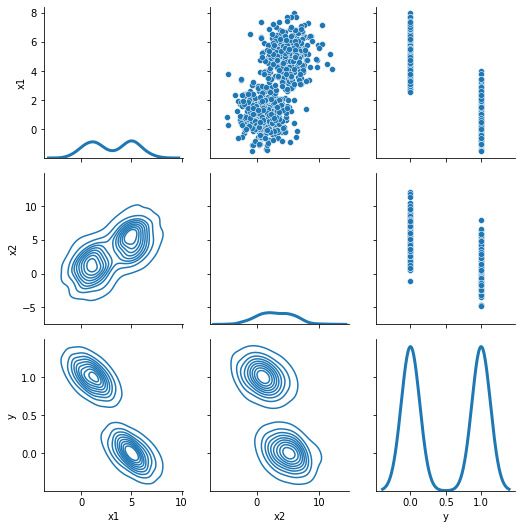

In [ ]:
data = raw_data('/content/BC-Train1.csv')
sns.displot(data, x="x1", hue="y", kind="kde", bw_adjust=.5, multiple='stack')
sns.jointplot(
    data=data,
    x="x1", y="x2", hue="y",
    kind="kde", multiple='stack'
)

# palette = sns.color_palette("Set2")
palette = sns.color_palette("tab10")
g = sns.PairGrid(data, palette=palette)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)



Train Accuracy :  0.99125
Test Accuracy :  1.0
